In [1]:
from IPython.display import clear_output

In [2]:
!pip install transformers -U 
!pip install data-science-types
!pip install datasets
clear_output()

In [3]:
from transformers import BertTokenizer, BertTokenizerFast, DistilBertTokenizerFast, XLNetTokenizerFast
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification, Trainer, TrainingArguments, DistilBertForSequenceClassification, XLNetForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup

import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from tqdm.notebook import tqdm
import pandas as pd
from dataclasses import dataclass

import os
import random
import numpy as np

from sklearn.model_selection import train_test_split, KFold

In [4]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [5]:
@dataclass
class Config:
    MAX_LEN = 256
    TRAIN_BATCH_SIZE = 3
    VALID_BATCH_SIZE = 3
    LR = 1e-05
    EMBED_DIM = 128
    EPOCHS = 10
    CSV_FILE = "/PURE_data_docs - Legacy only security.csv"
    MODEL_NAME = "bert-base-uncased"
    DISTIL_BERT = "distilbert-base-uncased"
    TEST_SIZE = 0.2
    RANDOM_STATE = 42
    EPS = 1e-8

config = Config()

In [6]:
def read_csv(filepath:str, field_req:str, field_lab:str): 
  df = pd.read_csv(filepath)
  requirements_count = df[field_req].count()
  labels = df[field_lab].value_counts()

  return df, requirements_count, labels

In [7]:
path = os.getcwd() + config.CSV_FILE
df, requirements_count, labels = read_csv(path, 'Requirement', 'Label')
print(f"Number of requirements: {requirements_count}")
df.head()

Number of requirements: 1094


,Requirement,Context (Keywords),Name of Doc,Sec/NotSec,Labeled by,Comments,Label,Labeled by.1,Comments.1,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
0,The System must allow the user to limit access...,Access Module,cctns.pdf,1,Кирилл,NaN,Access control,Aydar,Not sure,All existing keywords:,Number of entries:,All existing labels:,Number of entries:,Accepted labels:,NaN
1,The system should provide for role-based contr...,Access Module,cctns.pdf,1,Кирилл,NaN,Access control,Aydar,NaN,Access Module,11,Access control,79,Confidentiality,358.0
2,The System must allow a user to be a member of...,Access Module,cctns.pdf,1,Кирилл,NaN,Access control,Aydar,NaN,Usability,1,Other,51,Integrity,254.0
3,The System must allow only admin-users to set ...,Access Module,cctns.pdf,1,Кирилл,NaN,Access control,Aydar,NaN,Security Requirements,51,Confidentiality,358,Availability,45.0
4,The System should allow a user to stipulate wh...,Access Module,cctns.pdf,1,Кирилл,NaN,Access control,Aydar,NaN,Functional requirements,55,Accountability,140,Accountability,140.0


In [8]:
labels

Confidentiality                             358
Integrity                                   254
Accountability                              140
Operational                                 132
Access control                               79
Other                                        51
Availability                                 45
Operational?                                  7
I don't know                                  7
Functional                                    5
Confidentiality?                              4
Operational/Accountability                    3
continue                                      2
Availability?                                 2
Integrity?                                    2
Confidentiality/Integrity/Access control      1
Access control?                               1
Availability/Confidentiality/Integrity        1
Name: Label, dtype: int64

In [9]:
def prepare_requirements_and_plot(df:pd.DataFrame, min_len:int, field_req:str, field_lab:str): 
  prepared_df = df.copy(deep=True)
  df_proceed = prepared_df[prepared_df.groupby(field_lab)[field_lab]
                   .transform('count')>min_len]

  df_proceed = df_proceed[df.Label != 'Other']
  requirements_count = df_proceed[field_req].count()
  print(f"Requirements count: {requirements_count}")

  df_proceed.Label.value_counts().sort_index(ascending=False).plot(kind='barh')

  requirements_only = df_proceed[['Requirement', 'Label']]

  return df_proceed, requirements_count, requirements_only

Requirements count: 1008


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


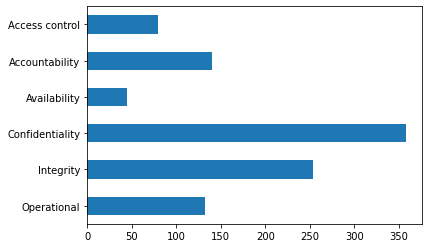

In [10]:
df_proceed, requirements_count, requirements_only = prepare_requirements_and_plot(df, 7, 'Requirement', 'Label')

In [11]:
requirements_only.head()

,Requirement,Label
0,The System must allow the user to limit access...,Access control
1,The system should provide for role-based contr...,Access control
2,The System must allow a user to be a member of...,Access control
3,The System must allow only admin-users to set ...,Access control
4,The System should allow a user to stipulate wh...,Access control


In [12]:
def label_requirements_with_idx(requirements: pd.DataFrame, field:str): 
  labels = requirements[field].unique()
  label_to_idx = dict()

  for idx, label in enumerate(labels): 
    label_to_idx[f"{label}"] = idx

  requirements_only = requirements.copy(deep=True)
  requirements_only["Index"] = requirements_only.Label.apply(lambda x: label_to_idx[x])

  return requirements_only, label_to_idx

In [13]:
requirements_only, label_to_idx = label_requirements_with_idx(requirements_only, 'Label')
requirements_only.head()

,Requirement,Label,Index
0,The System must allow the user to limit access...,Access control,0
1,The system should provide for role-based contr...,Access control,0
2,The System must allow a user to be a member of...,Access control,0
3,The System must allow only admin-users to set ...,Access control,0
4,The System should allow a user to stipulate wh...,Access control,0


In [14]:
label_to_idx

{'Access control': 0,
 'Accountability': 2,
 'Availability': 4,
 'Confidentiality': 1,
 'Integrity': 3,
 'Operational': 5}

# Trainer

In [24]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [25]:
requirements_only.head()

,Requirement,Label,Index
0,The System must allow the user to limit access...,Access control,0
1,The system should provide for role-based contr...,Access control,0
2,The System must allow a user to be a member of...,Access control,0
3,The System must allow only admin-users to set ...,Access control,0
4,The System should allow a user to stipulate wh...,Access control,0


In [26]:
class PUREDataset(torch.utils.data.Dataset):
    def __init__(self, requirements, encoder):
        self.requirements = requirements
        self.encoder = encoder
        self.encodings = tokenizer(list(self.requirements['Requirement'].values), truncation=True, padding=True)
        self.labels = self.requirements.Index.values

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]).to(device) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).to(device)
        return item

    def __len__(self):
        return len(self.labels)

train, test = train_test_split(requirements_only, test_size=0.1, random_state=42)
print(len(requirements_only['Requirement'].values))

train_dataset = PUREDataset(train, tokenizer)
test_dataset = PUREDataset(test, tokenizer)
print(len(train_dataset), len(test_dataset))

1008
907 101


In [27]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import TrainingArguments


def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

training_args = TrainingArguments(
    save_strategy="no",
    output_dir='./results',          # output directory
    num_train_epochs=20,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    evaluation_strategy='epoch',
    eval_steps=300,
    logging_strategy="no"
)

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [29]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [30]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',
                                                      num_labels=len(label_to_idx))
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,             # evaluation dataset
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classi

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.578927,0.445545,0.074257,0.166667,0.102740
2,No log,1.307042,0.534653,0.554640,0.313950,0.315232
3,No log,1.064296,0.633663,0.425234,0.481176,0.431816
4,No log,0.907120,0.712871,0.481206,0.540578,0.508983
5,No log,1.023923,0.653465,0.733371,0.654538,0.638134
6,No log,0.891965,0.673267,0.770036,0.615293,0.626366
7,No log,1.069360,0.623762,0.684714,0.677686,0.646010
8,No log,1.180740,0.673267,0.731790,0.674410,0.652191
9,No log,0.969965,0.732673,0.741405,0.722273,0.697079
10,No log,1.358951,0.732673,0.682842,0.812230,0.720669


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

TrainOutput(global_step=1140, training_loss=0.3935257225705866, metrics={'train_runtime': 631.3121, 'train_samples_per_second': 1.806, 'total_flos': 0, 'epoch': 20.0, 'init_mem_cpu_alloc_delta': 0, 'init_mem_gpu_alloc_delta': 268965376, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': -343617536, 'train_mem_gpu_alloc_delta': 813478400, 'train_mem_cpu_peaked_delta': 347824128, 'train_mem_gpu_peaked_delta': 1137910784})

In [34]:
!rm -rf logs/
!rm -rf results/
!rm -rf data_volume/

{'f1': 0.7286446520329578}


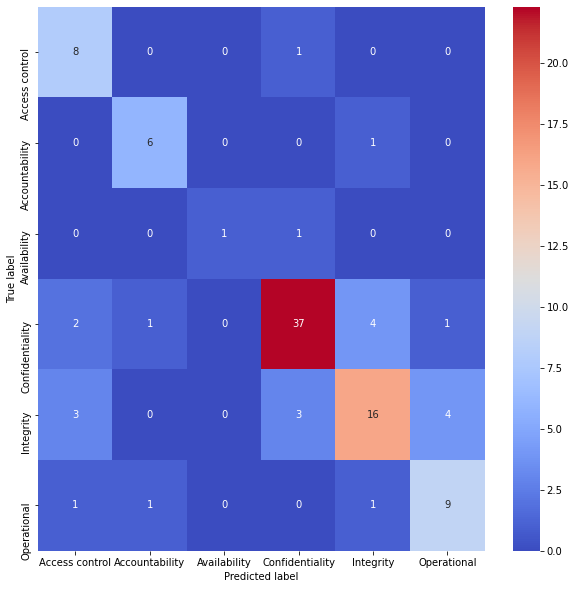

In [33]:
from datasets import load_metric
from sklearn.metrics import confusion_matrix
metric = load_metric('f1')

model.eval()
y_true, y_pred = [], []

for i in range(len(test_dataset)):
    inputs = test_dataset[i]
    # print(item)

    a, b, c = inputs['input_ids'], inputs['attention_mask'], inputs['labels']
    a = a.unsqueeze(0)
    b = b.unsqueeze(0)
    c = c.unsqueeze(0)
    model_predictions = model(a, attention_mask=b, labels=c)
    model_predictions = model_predictions.logits.argmax(dim=1)
    y_true.append(c.item())
    y_pred.append(model_predictions.item())
    # print(model_predictions, c)
    metric.add_batch(predictions=model_predictions, references=c)

confusion_matrix(y_true, y_pred)
final_score = metric.compute(average='macro')
print(final_score)

decode_dict = {value:key for key, value in label_to_idx.items()}

import seaborn as sn
import matplotlib.pyplot as plt

data = {'y_Actual':    [decode_dict[y] for y in y_true],
        'y_Predicted': [decode_dict[y] for y in y_pred]
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['True label'], colnames=['Predicted label'])

fig, ax = plt.subplots(figsize=(10,10))
sn.heatmap(confusion_matrix, annot=True, cmap="coolwarm", robust=True)
plt.show()

fig.savefig('heatmap.png', dpi=400)

In [ ]:
# MODEL_PATH = os.getcwd() + "/model/"
# print(MODEL_PATH)
# model.save_pretrained(os.path.join(MODEL_PATH, "distilbert.pt"))
# tokenizer.save_pretrained(os.getcwd() + "/tokenizer")

In [ ]:
# import shutil
# shutil.make_archive('model', 'zip', 'model')